In [1]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import pywt 


SEED = 1
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal


labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()

100%|██████████| 105/105 [00:00<00:00, 1052.61it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


<h2>Downsampling 

In [2]:
# because of te curse of dimensionality --> undersampling 

from scipy.signal import resample

ids_128 = df[df['frequencies'] == 128].index.tolist() # 65 signals are sampled using fs = 128
ids_250 = df[df['frequencies'] == 250].index.tolist() # 65 signals are sampled using fs = 128
sampled_len =  len(df.iloc[ids_250[0]]['ecg_lead_1'])
resampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])

for id in tqdm(ids_250):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)


100%|██████████| 40/40 [00:05<00:00,  6.87it/s]


<h2>Bandpass filtering

In [3]:
#Preprocessing used in practical lessons
from scipy.signal import resample, butter, lfilter, iirnotch

def notch_filter(cutoff, fs, q=30):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a


def bandpass_filter(data, filter_order=6, lowcut = .8, highcut = 45, signal_freq=128):
    """
    Method responsible for creating and applying Butterworth filter.
    :param deque data: raw data
    :param float lowcut: filter lowcut frequency value
    :param float highcut: filter highcut frequency value
    :param int signal_freq: signal frequency in samples per second (Hz)
    :param int filter_order: filter order
    :return array: filtered data
    """
    powerline = 60
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    y = lfilter(b, a, data,zi = None)
    #b,a = notch_filter(powerline,signal_freq)
    #y = lfilter(b,a,y)
    return y



filtered_df = df.copy(deep= True)

ids = filtered_df.index.tolist()

for id_ in tqdm(ids):
    
    row = filtered_df.iloc[id_]
    first = row['ecg_lead_1']
    second = row['ecg_lead_2']
    filtered_first = np.asarray(bandpass_filter(first))
    filtered_second =  np.asarray(bandpass_filter(second))

    filtered_df.iloc[id_]['ecg_lead_1'] = pd.Series(filtered_first)
    filtered_df.iloc[id_]['ecg_lead_2'] = pd.Series(filtered_second)

100%|██████████| 105/105 [00:02<00:00, 42.88it/s]


<h2>Scaling to [0:1] in 10 seconds time window 

In [4]:
import heartpy as hp

fs = 128
time_window = 10
samples = fs * time_window ##

for id in tqdm(filtered_df.index.tolist()):
    row = filtered_df.loc[id]
    first_lead = row['ecg_lead_1']
    second_lead = row['ecg_lead_2']
    l_ = len(first_lead)
    scaled_1 = list()
    scaled_2 = list()
#    
    for i in range(int(l_/samples)):
        to_scale_1 = first_lead[i*samples:i*samples+samples] 
        to_scale_2 = second_lead[i*samples:i*samples+samples]
#        
        scaled_1 += list(hp.scale_data(to_scale_1,lower=0,upper=1))
        scaled_2 += list(hp.scale_data(to_scale_2,lower=0,upper=1))
 ##   
    filtered_df.loc[id]['ecg_lead_1'] = scaled_1
    filtered_df.loc[id]['ecg_lead_2'] = scaled_2

100%|██████████| 105/105 [00:23<00:00,  4.39it/s]


<h2>Outliers detection and removal using zscore</h2>

In [5]:
from scipy import stats

# Function for the computation of rhythm data 
def get_2ECG_rhythmfeatures(data):
  
  #   mean
  mean_lead = np.mean(data)

  #   median
  median_lead = np.median(data)

  #   standard deviation
  std_lead = np.std(data)

  #   variance
  var_lead = stats.tvar(data)

  #   Skewness
  skew_lead = stats.skew(data)

  #   Kurtosis
  kurt_lead = stats.kurtosis(data)

  features = np.hstack([mean_lead,median_lead,std_lead,var_lead,skew_lead,kurt_lead])

  return features
#-------------------------------------------------------------------------------

#Training

features_rhythm_lead1 = list()
features_rhythm_lead2 = list()


for i in range(filtered_df.shape[0]):
  tmp_lead1 = get_2ECG_rhythmfeatures(filtered_df['ecg_lead_1'][i])
  features_rhythm_lead1.append(tmp_lead1)
  tmp_lead2 = get_2ECG_rhythmfeatures(filtered_df['ecg_lead_2'][i])
  features_rhythm_lead2.append(tmp_lead2)

features_rhythm_lead1 = pd.DataFrame(features_rhythm_lead1, columns = ['mean_lead1', 'median_lead1', 'std_lead1', 'var_lead1', 'skew_lead1','kurt_lead1'])
features_rhythm_lead2 = pd.DataFrame(features_rhythm_lead2, columns = ['mean_lead2', 'median_lead2', 'std_lead2', 'var_lead2', 'skew_lead2','kurt_lead2'])

features_rhythm = pd.concat([features_rhythm_lead1, features_rhythm_lead2], axis=1)

features = pd.DataFrame(features_rhythm, columns = ['mean_lead1', 'median_lead1', 'std_lead1', 'var_lead1', 'skew_lead1','kurt_lead1',
                                                    'mean_lead2', 'median_lead2', 'std_lead2', 'var_lead2', 'skew_lead2','kurt_lead2'])
display(features) 

,mean_lead1,median_lead1,std_lead1,var_lead1,skew_lead1,kurt_lead1,mean_lead2,median_lead2,std_lead2,var_lead2,skew_lead2,kurt_lead2
0,0.476086,0.474618,0.128357,0.016476,0.065871,3.853435,0.600828,0.613177,0.119664,0.014319,-1.328497,6.504245
1,0.309628,0.315643,0.118704,0.014091,2.242173,11.961672,0.662428,0.672944,0.144363,0.020841,-1.038713,3.939288
2,0.462381,0.466913,0.122431,0.014989,-0.007802,2.618824,0.570732,0.586303,0.134329,0.018044,-0.788964,3.169306
3,0.399816,0.366260,0.149092,0.022228,0.955791,1.976279,0.658729,0.681179,0.162172,0.026300,-1.171663,1.827310
4,0.478230,0.488412,0.131123,0.017193,-0.046548,4.308083,0.555436,0.561574,0.148968,0.022191,-0.156231,1.414820
...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.394100,0.385903,0.132414,0.017534,0.582383,1.942821,0.426588,0.419286,0.116018,0.013460,0.446691,2.379165
101,0.437926,0.430825,0.127339,0.016215,0.479884,3.274700,0.444411,0.452348,0.126760,0.016068,0.327382,3.613294
102,0.345843,0.332378,0.115116,0.013252,1.653328,6.466284,0.403117,0.404505,0.114159,0.013032,0.996624,6.575469
103,0.514950,0.522097,0.098893,0.009780,-0.152302,9.197804,0.461116,0.445006,0.129433,0.016753,0.508997,1.575390


In [6]:
def plot_outliersAnalysis(abs_zscores):
  # number of outliers per subject 
  bool_zscores = (abs_zscores > 3).sum(axis=1)
  bool_zscores.hist()
  plt.title("Number of outliers per subject")
  plt.show()

  # number of outliers per feature 
  bool_zscores = (abs_zscores > 3).sum(axis=0)
  #bool_zscores.hist(bins = len(feature_list))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])

  ax.bar(feature_list,bool_zscores)
  plt.title("Number of outliers per feature")
  plt.xticks(np.arange(len(feature_list)), feature_list,rotation=90)
  plt.show()
  return

Train subjects before outlier removal: (105, 12)
Train subjects after outlier removal: (99, 12)


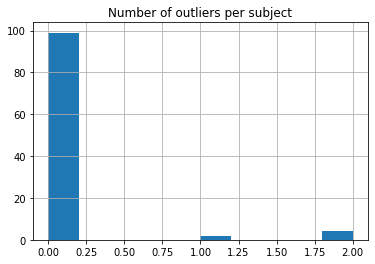

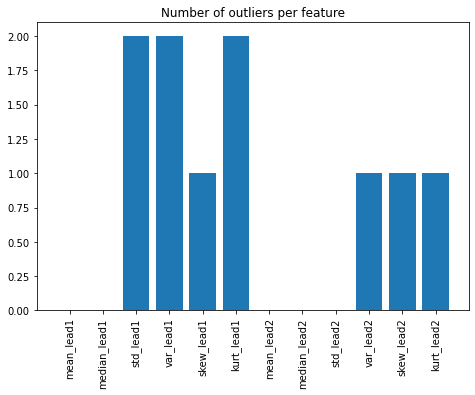

,mean_lead1,median_lead1,std_lead1,var_lead1,skew_lead1,kurt_lead1,mean_lead2,median_lead2,std_lead2,var_lead2,skew_lead2,kurt_lead2
0,0.476086,0.474618,0.128357,0.016476,0.065871,3.853435,0.600828,0.613177,0.119664,0.014319,-1.328497,6.504245
1,0.309628,0.315643,0.118704,0.014091,2.242173,11.961672,0.662428,0.672944,0.144363,0.020841,-1.038713,3.939288
2,0.462381,0.466913,0.122431,0.014989,-0.007802,2.618824,0.570732,0.586303,0.134329,0.018044,-0.788964,3.169306
3,0.399816,0.366260,0.149092,0.022228,0.955791,1.976279,0.658729,0.681179,0.162172,0.026300,-1.171663,1.827310
4,0.478230,0.488412,0.131123,0.017193,-0.046548,4.308083,0.555436,0.561574,0.148968,0.022191,-0.156231,1.414820
...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.394100,0.385903,0.132414,0.017534,0.582383,1.942821,0.426588,0.419286,0.116018,0.013460,0.446691,2.379165
101,0.437926,0.430825,0.127339,0.016215,0.479884,3.274700,0.444411,0.452348,0.126760,0.016068,0.327382,3.613294
102,0.345843,0.332378,0.115116,0.013252,1.653328,6.466284,0.403117,0.404505,0.114159,0.013032,0.996624,6.575469
103,0.514950,0.522097,0.098893,0.009780,-0.152302,9.197804,0.461116,0.445006,0.129433,0.016753,0.508997,1.575390


In [7]:
from scipy.stats import zscore
import numpy as np

feature_list = features.columns.tolist()
print('Train subjects before outlier removal: ' + str(features.shape))

# apply zscore
zscore_features = features.apply(zscore, axis=0)

# select all those values with zscore < -+ 3 and discard outliers 
abs_zscores = np.abs(zscore_features)
filtered_entries = (abs_zscores < 3).all(axis=1)

features_or = features[filtered_entries]

print('Train subjects after outlier removal: ' + str(features_or.shape))


plot_outliersAnalysis(abs_zscores)
display(features_or)

In [8]:
features_or.index
filtered_df = filtered_df.loc[features_or.index]

<h2> RR distances analysis

In [9]:
signal_ids = filtered_df.index.tolist()
RR_dict = {}

for id_ in tqdm(signal_ids):  
  sig_Id = df.iloc[id_]['sigId']
  RR_dict[sig_Id] = {}
  RR_dict[sig_Id]['RR_distances'] = list()
  RR_dict[sig_Id]['S_distances'] = list()
  
  peaks = df.iloc[id_]['peaks']
  labels = df.iloc[id_]['labels']

  for i,p in enumerate(peaks[1:-1]):
    RR_distance = p-peaks[i]
    if(RR_distance < 250): # discard outliers
      RR_dict[sig_Id]['RR_distances'].append(RR_distance)
      if(labels[i+1] == 'S'):
        RR_dict[sig_Id]['S_distances'].append(RR_distance)

  RR_dict[sig_Id]['RR_distances'] = np.asarray(RR_dict[sig_Id]['RR_distances'])
  RR_dict[sig_Id]['S_distances'] = np.asarray(RR_dict[sig_Id]['S_distances'])

  RR_dict[sig_Id]['Avg_RR_distance'] = RR_dict[sig_Id]['RR_distances'].mean()
  RR_dict[sig_Id]['AVG_S_distance'] = RR_dict[sig_Id]['S_distances'].mean()


RR_df = pd.DataFrame.from_dict(RR_dict,orient="index")
RR_df.tail()

  0%|          | 0/99 [00:00<?, ?it/s]C:\Users\simon\AppData\Local\Temp/ipykernel_11364/1816920695.py:24: RuntimeWarning: Mean of empty slice.
  RR_dict[sig_Id]['AVG_S_distance'] = RR_dict[sig_Id]['S_distances'].mean()
100%|██████████| 99/99 [00:00<00:00, 237.56it/s]


,RR_distances,S_distances,Avg_RR_distance,AVG_S_distance
S114,"[117, 116, 115, 112, 113, 114, 114, 112, 116, ...",[],114.914745,NaN
S115,"[113, 118, 80, 151, 118, 123, 76, 152, 119, 11...",[73],89.041006,73.000000
S116,"[143, 145, 141, 146, 143, 142, 144, 142, 143, ...",[75],122.611082,75.000000
S117,"[142, 143, 147, 148, 145, 139, 148, 139, 140, ...","[119, 99, 92, 100, 99, 92, 91, 92, 89, 87, 82,...",106.363048,83.558719
S118,"[85, 84, 86, 81, 82, 85, 81, 83, 83, 82, 84, 8...",[],93.967755,NaN


In [10]:
import heartpy as hp 

classes = np.array(["N","S","V"])

patch_length = 350 

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_dataset(df):
    
    dataset_dict = {}
    ids = df['sigId']
   
    for id in tqdm(ids):
        row = df[df['sigId'] == id]
        sigId = row['sigId'].values[0]
        peaks = row['peaks'].values[0]
        first_lead_signal = row['ecg_lead_1'].values[0]
        second_lead_signal = row['ecg_lead_2'].values[0]
        labels = row['labels'].values[0]
        avg_RR = RR_df.loc[sigId]['Avg_RR_distance'] # T for the signal 

        for i,peak in enumerate(peaks):
            
            stringIdx = str(sigId)+'_'+str(i)    
            dataset_dict[stringIdx] = {}
            dataset_dict[stringIdx]["first_lead"] = list()
            dataset_dict[stringIdx]["second_lead"] = list()
            size = list(range(int(peak-(avg_RR)),int(peak+avg_RR)))

            for s in size:
                if(s < 0 or s >= len(first_lead_signal)):
                    dataset_dict[stringIdx]["first_lead"].append(0.5)
                    dataset_dict[stringIdx]["second_lead"].append(0.5)
                else:
                    dataset_dict[stringIdx]["first_lead"].append(first_lead_signal[s])
                    dataset_dict[stringIdx]["second_lead"].append(second_lead_signal[s])
            
            first_lead = dataset_dict[stringIdx]["first_lead"][:]
            second_lead = dataset_dict[stringIdx]["second_lead"][:]
            
            first_lead = resample(first_lead,patch_length)
            second_lead = resample(second_lead,patch_length)
            
            dataset_dict[stringIdx]["first_lead"] = first_lead[:]
            dataset_dict[stringIdx]["second_lead"] = second_lead[:]
            
            #dataset_dict[stringIdx]["dwt_1"] = pywt.dwt(first_lead,'db4','constant')
            #dataset_dict[stringIdx]["dwt_2"] = pywt.dwt(second_lead,'db4','constant')

            #dataset_dict[stringIdx]["dwt_1"] = pywt.wavedec(first_lead, 'db3', level=2)
            #dataset_dict[stringIdx]["dwt_2"] = pywt.wavedec(second_lead, 'db3', level=2)
            
            dataset_dict[stringIdx]["stringLabel"] = labels[i]
            dataset_dict[stringIdx]["label"] = convert_to_one_hot(labels[i])

    dataset_df = pd.DataFrame.from_dict(dataset_dict,orient="index")
    return dataset_df

<h2> Split dataset by patient & creation of patches

In [11]:

training_df, test_df_ = train_test_split(filtered_df,test_size = 0.2,random_state=SEED)
validation_df, test_df = train_test_split(test_df_,test_size = 0.5,random_state=SEED)

training_patches_df_ = create_patch_dataset(training_df)
validation_patches_df_ = create_patch_dataset(validation_df)
test_patches_df = create_patch_dataset(test_df)


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


<h2> Drop and resampling 

How many training indx: 170577
Balancing training...
pre drop: 185452
post drop:31935
20802
225
871
Balancing validation


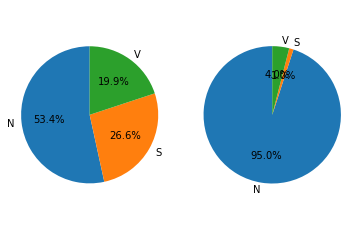

In [12]:
training_patches_df = training_patches_df_.copy(deep=True)
validation_patches_df = validation_patches_df_.copy(deep=True)

training_df.head()

training_patients = training_df['sigId']
validation_patients = validation_df['sigId']

# calculate percentage of heartbeats to drop 

num_n = len(training_patches_df[(training_patches_df['stringLabel']=='N')])
num_s = len(training_patches_df[(training_patches_df['stringLabel']=='S')])
num_v = len(training_patches_df[(training_patches_df['stringLabel']=='V')])
to_drop = num_n - max(num_s,num_v) * 2
perc_to_drop_train = to_drop/(num_n)

num_n = len(validation_patches_df[(validation_patches_df['stringLabel']=='N')])
num_s = len(validation_patches_df[(validation_patches_df['stringLabel']=='S')])
num_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='V')])
to_drop = 0
perc_to_drop_valid = 0

train_indexes = training_patches_df.index[training_patches_df['stringLabel'] == 'N'].tolist()
valid_indexes = validation_patches_df.index[validation_patches_df['stringLabel'] == 'N'].tolist()

print(f"How many training indx: {len(train_indexes)}")

train_to_drop = list()
valid_to_drop = list()
lengths = list()
dict_train = {}
valid_train = {}

print("Balancing training...")

for p in training_patients:
    dict_train[p] = list()

for hb in train_indexes:
    dict_train[hb.split('_')[0]].append(hb)

for p in dict_train:
   random.shuffle(dict_train[p])

for k in dict_train:
    train_to_drop += dict_train[k][:int(len(dict_train[k]) * perc_to_drop_train)]

print(f"pre drop: {len(training_patches_df.index)}")
training_patches_df = training_patches_df.drop(train_to_drop)
print(f"post drop:{len(training_patches_df.index)}")
print(num_n)
print(num_s)
print(num_v)
print("Balancing validation")

for p in validation_patients:
    valid_train[p] = list()
    
for hb in valid_indexes:
    valid_train[hb.split('_')[0]].append(hb)

for p in valid_train:
    random.shuffle(valid_train[p])

for k in valid_train:
    valid_to_drop += valid_train[k][:int(perc_to_drop_valid * len(valid_train[k]))]

validation_balanced_patches_df = validation_patches_df.drop(valid_to_drop)


training_labels = training_patches_df['stringLabel'].values
validation_labels = validation_balanced_patches_df['stringLabel'].values

classes = ["N","S","V"]

training_counts = [0]*3
validation_counts = [0]*3

for l in training_labels:
    training_counts[classes.index(l)] += 1
for l in validation_labels:
    validation_counts[classes.index(l)] += 1

fig1, (ax1,ax2) = plt.subplots(1,2)

ax1.pie(training_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  
ax2.pie(validation_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal')  

fig1.set_facecolor("white")

plt.show()


In [13]:
# resample v and s
from sklearn.utils import shuffle


ids_S = training_patches_df.index[training_patches_df['stringLabel']=='S']
ids_V = training_patches_df.index[training_patches_df['stringLabel']=='V']
ids_N = training_patches_df.index[training_patches_df['stringLabel']=='N']

to_add = {}

to_resample_s = len(ids_N) - len(ids_S)
to_resample_v = len(ids_N) - len(ids_V)

for i in tqdm(range(to_resample_s)):
    id = random.choice(ids_S)
    row = training_patches_df.loc[id]
    idx = id + '_' + str(i)
    to_add[idx] = {}
    to_add[idx]['first_lead'] = row['first_lead']
    to_add[idx]['second_lead'] = row['second_lead']
    to_add[idx]['stringLabel'] = row['stringLabel']
    to_add[idx]['label'] = row['label']



for i in tqdm(range(to_resample_v)):
    id = random.choice(ids_V)
    row = training_patches_df.loc[id]
    idx = id + '_i'
    to_add[idx] = {}
    to_add[idx]['first_lead'] = row['first_lead']
    to_add[idx]['second_lead'] = row['second_lead']
    to_add[idx]['stringLabel'] = row['stringLabel']
    to_add[idx]['label'] = row['label']


to_add_df = pd.DataFrame.from_dict(to_add,orient="index")
training_patches_df = pd.concat([training_patches_df,to_add_df],axis=0) 
training_patches_df = shuffle(training_patches_df)


100%|██████████| 10695/10695 [00:00<00:00, 10850.25it/s]


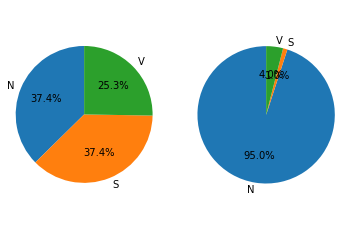

In [14]:

training_labels = training_patches_df['stringLabel'].values
validation_labels = validation_balanced_patches_df['stringLabel'].values

classes = ["N","S","V"]

training_counts = [0]*3
validation_counts = [0]*3

for l in training_labels:
    training_counts[classes.index(l)] += 1
for l in validation_labels:
    validation_counts[classes.index(l)] += 1

fig1, (ax1,ax2) = plt.subplots(1,2)

ax1.pie(training_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  
ax2.pie(validation_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal')  

fig1.set_facecolor("white")

plt.show()

In [15]:
def create_input(df):
    
    x = list()
    y = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead'],row['second_lead']]).astype(np.float32)))
        y.append(row['label'])

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    
    return x,y


In [16]:
x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_patches_df)
x_test,y_test = create_input(test_patches_df)

100%|██████████| 22488/22488 [00:01<00:00, 13122.62it/s]


In [17]:
def create_autoencoder_input(df):
    x = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead']]).astype(np.float32)))

    x = np.asarray(x).astype(np.float32)
    
    return x

In [18]:
x_autoencoder = create_autoencoder_input(training_patches_df)
x_valid_auto = create_autoencoder_input(validation_patches_df)

100%|██████████| 21898/21898 [00:01<00:00, 14225.00it/s]


In [19]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 40 # 350/50 = 7 compression factor

input_shape = x_autoencoder.shape[1]

input = keras.Input(shape=input_shape,name='Input_layer')

# encoding 

dense1 = layers.Dense(512,activation='relu',name='Hidden_1')(input)
dropout1 = layers.Dropout(0.1,name='Dropout_1')(dense1)
dense2 = layers.Dense(256,activation='relu',name='Hidden_2')(dropout1)

encoded = layers.Dense(encoding_dim, activation='sigmoid',name='Encoded_input')(dense2)

dense3 = layers.Dense(256,activation='relu',name='Hidden_3')(encoded)
dropout2 = layers.Dropout(0.1,name='Dropout_2')(dense3)
dense4 = layers.Dense(512,activation='relu',name='Hidden_4')(dropout2)

# decoding

decoded = layers.Dense(input_shape, activation='sigmoid',name='Decoded_input')(dense4)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input, encoded)


# This is our encoded (32-dimensional) input
#encoded_input = keras.Input(shape=(,))
# Retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# Create the decoder model
#decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

dot_img_file = 'autencoder.png'
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
#autoencoder.summary()


tf.keras.utils.plot_model(autoencoder, to_file=dot_img_file, show_shapes=False)

history = autoencoder.fit(x_autoencoder, x_autoencoder,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_valid_auto, x_valid_auto))

Epoch 1/100
179/179 [==============================] - 6s 17ms/step - loss: 0.0234 - val_loss: 0.0119
Epoch 2/100
179/179 [==============================] - 1s 6ms/step - loss: 0.0136 - val_loss: 0.0095
Epoch 3/100
179/179 [==============================] - 1s 7ms/step - loss: 0.0117 - val_loss: 0.0090
Epoch 4/100
179/179 [==============================] - 1s 7ms/step - loss: 0.0109 - val_loss: 0.0084
Epoch 5/100
179/179 [==============================] - 1s 7ms/step - loss: 0.0097 - val_loss: 0.0074
Epoch 6/100
179/179 [==============================] - 1s 7ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 7/100
179/179 [==============================] - 1s 7ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 8/100
179/179 [==============================] - 1s 7ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 9/100
179/179 [==============================] - 1s 7ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 10/100
179/179 [==============================] - 1s 7ms/step - loss: 0.0063 - val_l

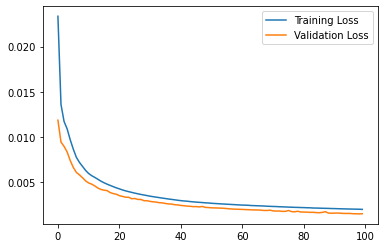

In [20]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [21]:
def plot_sample(signal):
    fig,ax = plt.subplots()
    x = list(range(len(signal)))
    ax.plot(x,signal)
    plt.show()

In [22]:
# try the autoencoder 

samples = x_autoencoder[:10000]



In [23]:

decoded = autoencoder.predict(samples)
encoded = encoder.predict(samples)


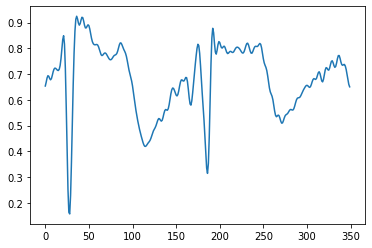

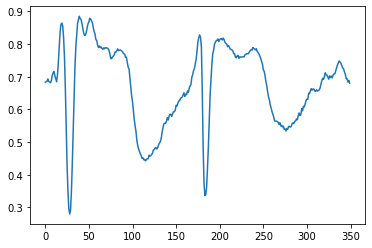

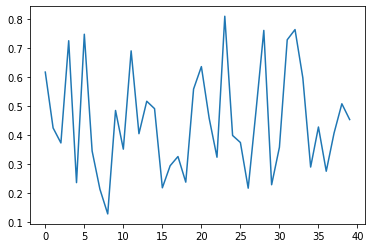

In [24]:
id = 1000
plot_sample(samples[id])
plot_sample(decoded[id])
plot_sample(encoded[id])

In [25]:
def encode_input(encoder,x_input):
    transformed = encoder.predict(x_input)
    return np.array(transformed)


x_encoded = encode_input(encoder,x_autoencoder)

In [26]:
import seaborn as sns 
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  #y_true = np.argmax(y_true,axis=1) already 1dimensional
  #y_pred = np.argmax(y_pred,axis=1)
  
  con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [27]:
def create_input(df):
    
    x = list()
    y = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead']]).astype(np.float32)))
        y.append(row['label'])

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    
    return x,y

In [28]:
from sklearn.svm import SVC


x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_patches_df)
x_test,y_test = create_input(test_patches_df)


x_train = encode_input(encoder,x_train)
x_valid = encode_input(encoder,x_valid)
x_test = encode_input(encoder,x_test)

print(x_train.shape)
print(y_train[0])

y_train = np.argmax(y_train,axis=1)
y_valid = np.argmax(y_valid,axis=1)
y_test = np.argmax(y_test,axis=1)


from sklearn.neighbors import KNeighborsClassifier

sv = SVC(C=5, kernel='rbf', degree=3,   # C is a regularization parameter -> the higher and the more we weights points outside the margin 
         gamma='scale', coef0=0.0, shrinking=True, 
         probability=False, tol=0.001, cache_size=200, 
         class_weight=None, verbose=False, max_iter=- 1, 
         decision_function_shape='ovr', break_ties=False, 
         random_state=SEED)

print("training ...",end="\r")
sv.fit(x_train,y_train)
print("Sv trained",end="\n")
print("Scoring:")
#sv.score(x_valid[:,:,0],y_valid)




100%|██████████| 22488/22488 [00:01<00:00, 11601.87it/s]


(45656, 40)
[1. 0. 0.]
Sv trained..
Scoring:


Validation

In [29]:
from sklearn.metrics import classification_report
y_pred = sv.predict(x_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     20802
           1       0.29      0.89      0.43       225
           2       0.95      0.93      0.94       871

    accuracy                           0.97     21898
   macro avg       0.75      0.93      0.79     21898
weighted avg       0.99      0.97      0.98     21898



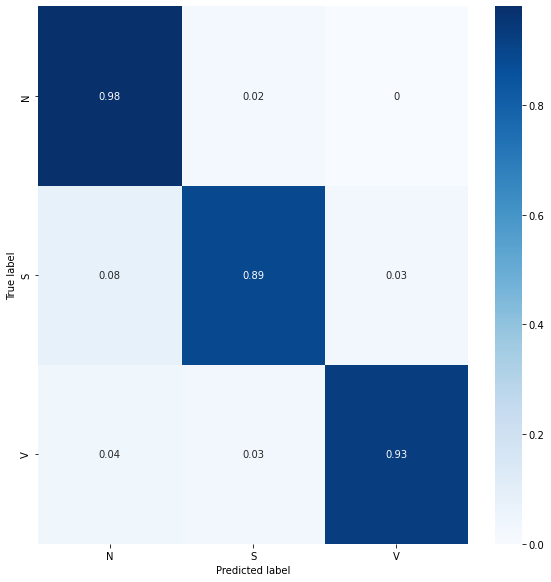

In [30]:
plot_confusion_matrix(y_valid,y_pred)

Test set

In [31]:

from sklearn.metrics import classification_report
y_pred = sv.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     21716
           1       0.55      0.79      0.65       389
           2       0.55      0.94      0.69       383

    accuracy                           0.97     22488
   macro avg       0.70      0.90      0.78     22488
weighted avg       0.98      0.97      0.98     22488



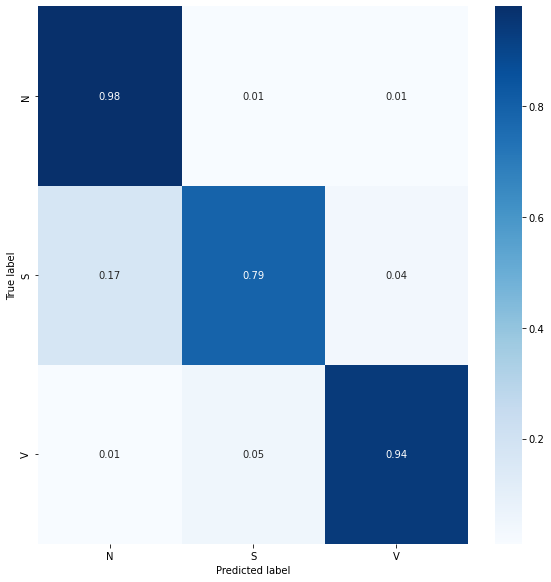

In [32]:
plot_confusion_matrix(y_test,y_pred)

<h2>KNN</h2>

In [33]:
import seaborn as sns 
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  y_true = np.argmax(y_true,axis=1)
  y_pred = np.argmax(y_pred,axis=1)
  
  con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [34]:
x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_patches_df)
x_test,y_test = create_input(test_patches_df)


x_train = encode_input(encoder,x_train)
x_valid = encode_input(encoder,x_valid)
x_test = encode_input(encoder,x_test)


100%|██████████| 22488/22488 [00:01<00:00, 19897.79it/s]


In [35]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=3,weights='distance',)
print("training ...",end="\r")
KNN.fit(x_train,y_train)
print("KNN trained",end="\n")


KNN trained.


validation

In [36]:
y_pred = KNN.predict(x_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     20802
           1       0.18      0.88      0.30       225
           2       0.73      0.72      0.73       871

   micro avg       0.94      0.94      0.94     21898
   macro avg       0.64      0.85      0.67     21898
weighted avg       0.98      0.94      0.96     21898
 samples avg       0.94      0.94      0.94     21898



C:\Users\simon\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


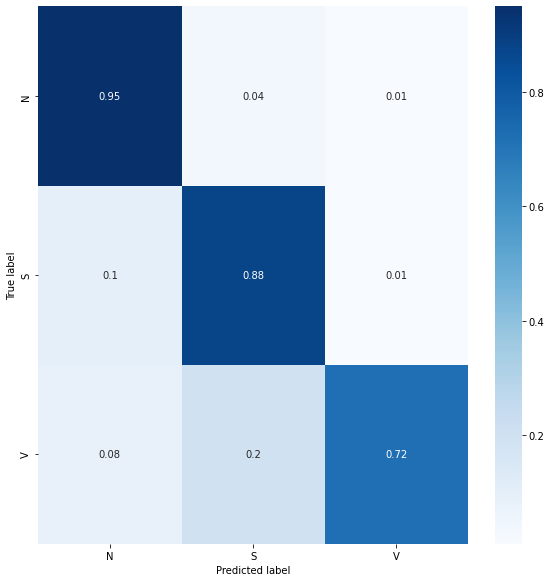

In [37]:
plot_confusion_matrix(y_valid, y_pred)

Test set

In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
y_pred = KNN.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     21716
           1       0.32      0.56      0.40       389
           2       0.50      0.92      0.65       383

   micro avg       0.96      0.96      0.96     22488
   macro avg       0.60      0.82      0.68     22488
weighted avg       0.98      0.96      0.97     22488
 samples avg       0.96      0.96      0.96     22488



C:\Users\simon\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


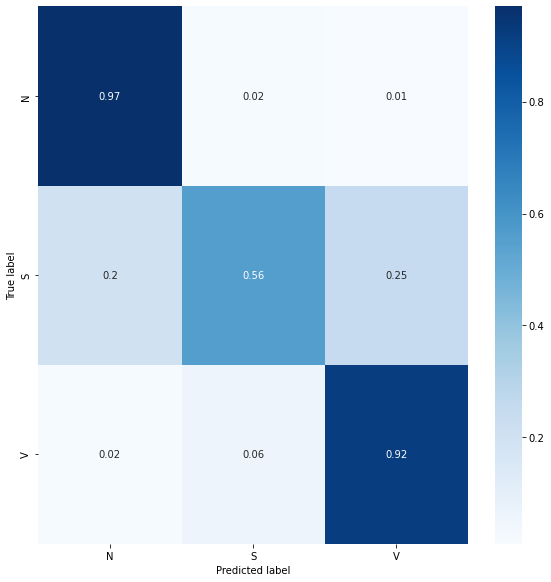

In [39]:
plot_confusion_matrix(y_test, y_pred)

<h2>RFC

In [40]:
from sklearn.ensemble import RandomForestClassifier

x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_balanced_patches_df)
x_test,y_test = create_input(validation_patches_df)

x_train = encode_input(encoder,x_train)
x_valid = encode_input(encoder,x_valid)
x_test = encode_input(encoder,x_test)


rf = RandomForestClassifier(
    n_estimators= 200,
    random_state= SEED,
)

rf.fit(x_train,y_train)

100%|██████████| 21898/21898 [00:01<00:00, 21047.25it/s]


RandomForestClassifier(n_estimators=200, random_state=1)

Validation

In [41]:
y_pred = rf.predict(x_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     20802
           1       0.51      0.71      0.59       225
           2       0.99      0.73      0.84       871

   micro avg       0.99      0.95      0.97     21898
   macro avg       0.83      0.80      0.80     21898
weighted avg       0.99      0.95      0.97     21898
 samples avg       0.95      0.95      0.95     21898



C:\Users\simon\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


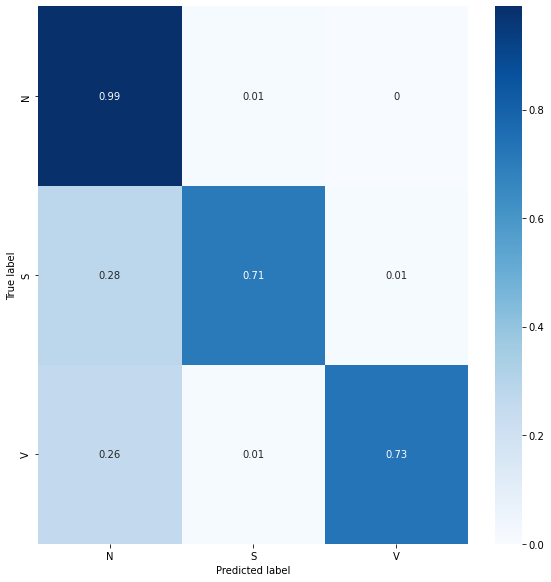

In [42]:
plot_confusion_matrix(y_valid, y_pred)

Test set 

In [43]:
y_pred = rf.predict(x_test)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     20802
           1       0.51      0.71      0.59       225
           2       0.99      0.73      0.84       871

   micro avg       0.99      0.95      0.97     21898
   macro avg       0.83      0.80      0.80     21898
weighted avg       0.99      0.95      0.97     21898
 samples avg       0.95      0.95      0.95     21898



C:\Users\simon\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


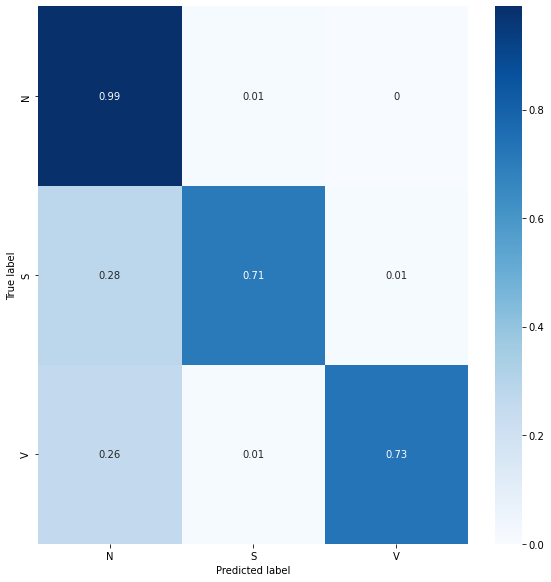

In [45]:
plot_confusion_matrix(y_test, y_pred)

<h2>Neural Network 

In [46]:

x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_patches_df)
x_test,y_test = create_input(test_patches_df)


x_train = encode_input(encoder,x_train)
x_valid = encode_input(encoder,x_valid)
x_test = encode_input(encoder,x_test)


100%|██████████| 22488/22488 [00:01<00:00, 20414.98it/s]


In [47]:
from keras.regularizers import l2

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

batch_size = 256

input_shape = x_train.shape[1]

input = keras.Input(shape=input_shape,name='Input_layer')

regularizer = l2(0.)

dense1 = layers.Dense(512,activation='relu',bias_regularizer=regularizer, activity_regularizer=regularizer)(input)
dropout1 = layers.Dropout(0.1,name='Dropout_1')(dense1)
dense2 = layers.Dense(512,activation='relu',bias_regularizer=regularizer, activity_regularizer=regularizer)(dropout1)
dropout2 = layers.Dropout(0.1)(dense2)
out = layers.Dense(3, activation='softmax')(dropout2)

classifier = keras.Model(input, out)

initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=int(x_train.shape[0]/batch_size)*25,
    decay_rate=0.75,
    staircase=True)


opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(opt)

classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',lr_metric])
history = classifier.fit(x_train, y_train,
                epochs=100,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_valid, y_valid))

Epoch 1/100
179/179 [==============================] - 3s 8ms/step - loss: 0.6007 - accuracy: 0.5070 - lr: 1.0000e-04 - val_loss: 0.5147 - val_accuracy: 0.6907 - val_lr: 1.0000e-04
Epoch 2/100
179/179 [==============================] - 1s 7ms/step - loss: 0.5221 - accuracy: 0.6255 - lr: 1.0000e-04 - val_loss: 0.4191 - val_accuracy: 0.7607 - val_lr: 1.0000e-04
Epoch 3/100
179/179 [==============================] - 1s 7ms/step - loss: 0.4541 - accuracy: 0.7011 - lr: 1.0000e-04 - val_loss: 0.3712 - val_accuracy: 0.7829 - val_lr: 1.0000e-04
Epoch 4/100
179/179 [==============================] - 1s 7ms/step - loss: 0.3926 - accuracy: 0.7618 - lr: 1.0000e-04 - val_loss: 0.2834 - val_accuracy: 0.8962 - val_lr: 1.0000e-04
Epoch 5/100
179/179 [==============================] - 1s 7ms/step - loss: 0.3407 - accuracy: 0.8041 - lr: 1.0000e-04 - val_loss: 0.2291 - val_accuracy: 0.9461 - val_lr: 1.0000e-04
Epoch 6/100
179/179 [==============================] - 1s 7ms/step - loss: 0.3030 - accuracy: 0

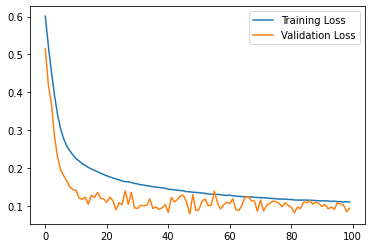

In [48]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

validation

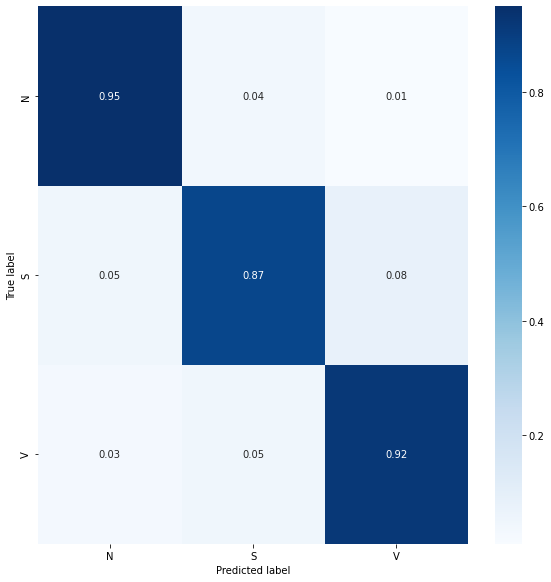

In [49]:
y_pred = classifier.predict(x_valid)
plot_confusion_matrix(y_valid, y_pred)

In [50]:
y_pred_ = np.argmax(y_pred,axis=1)
y_valid_ = np.argmax(y_valid,axis=1)

print(classification_report(y_valid_, y_pred_))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     20802
           1       0.19      0.87      0.31       225
           2       0.81      0.92      0.86       871

    accuracy                           0.95     21898
   macro avg       0.67      0.92      0.72     21898
weighted avg       0.98      0.95      0.96     21898



Test set

In [51]:
y_pred = classifier.predict(x_test)

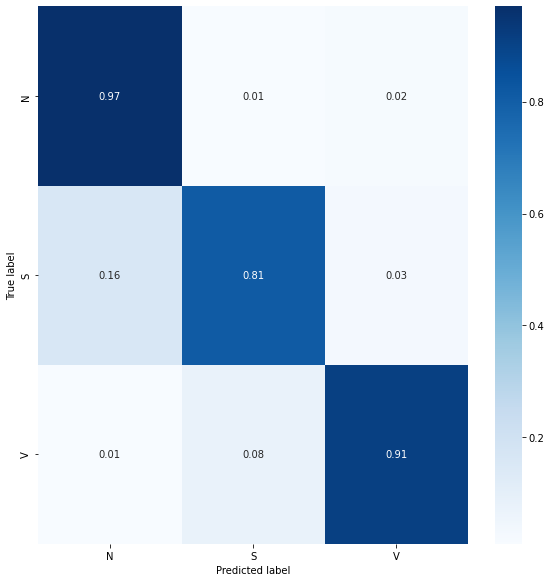

In [52]:
plot_confusion_matrix(y_test, y_pred)

In [53]:
#y_pred = np.argmax(y_pred,axis=-1)
y_pred_ = np.argmax(y_pred,axis=1)
y_test_ = np.argmax(y_test,axis=1)

print(classification_report(y_test_, y_pred_))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     21716
           1       0.48      0.81      0.60       389
           2       0.47      0.91      0.62       383

    accuracy                           0.96     22488
   macro avg       0.65      0.90      0.73     22488
weighted avg       0.98      0.96      0.97     22488



<h2> Without autoencoder

<h3>SVC

In [55]:
from sklearn.svm import SVC


x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_patches_df)
x_test,y_test = create_input(test_patches_df)

print(x_train.shape)
print(y_train[0])

y_train = np.argmax(y_train,axis=1)
y_valid = np.argmax(y_valid,axis=1)
y_test = np.argmax(y_test,axis=1)


from sklearn.neighbors import KNeighborsClassifier

sv = SVC(C=5, kernel='rbf', degree=3,   # C is a regularization parameter -> the higher and the more we weights points outside the margin 
         gamma='scale', coef0=0.0, shrinking=True, 
         probability=False, tol=0.001, cache_size=200, 
         class_weight=None, verbose=False, max_iter=- 1, 
         decision_function_shape='ovr', break_ties=False, 
         random_state=SEED)

print("training ...",end="\r")
sv.fit(x_train[:,:,0],y_train)
print("Sv trained",end="\n")
print("Scoring:")
#sv.score(x_valid[:,:,0],y_valid)


100%|██████████| 22488/22488 [00:01<00:00, 20970.34it/s]


(45656, 350, 1)
[1. 0. 0.]
Sv trained..
Scoring:


In [57]:
import seaborn as sns 
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  #y_true = np.argmax(y_true,axis=1) already 1dimensional
  #y_pred = np.argmax(y_pred,axis=1)
  
  con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

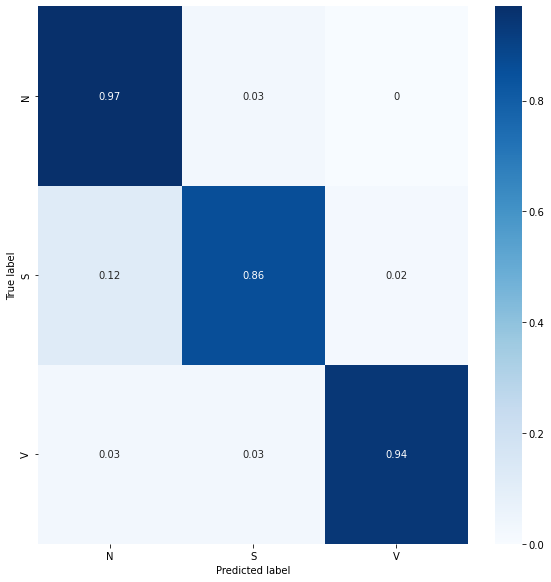

In [58]:
y_pred = sv.predict(x_valid[:,:,0])
plot_confusion_matrix(y_valid,y_pred)

In [59]:

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     20802
           1       0.25      0.86      0.39       225
           2       0.95      0.94      0.95       871

    accuracy                           0.97     21898
   macro avg       0.73      0.93      0.77     21898
weighted avg       0.99      0.97      0.98     21898



<h3> KNN 

In [60]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=3,weights='distance',)
print("training ...",end="\r")
KNN.fit(x_train[:,:,0],y_train)
print("KNN trained",end="\n")


KNN trained.


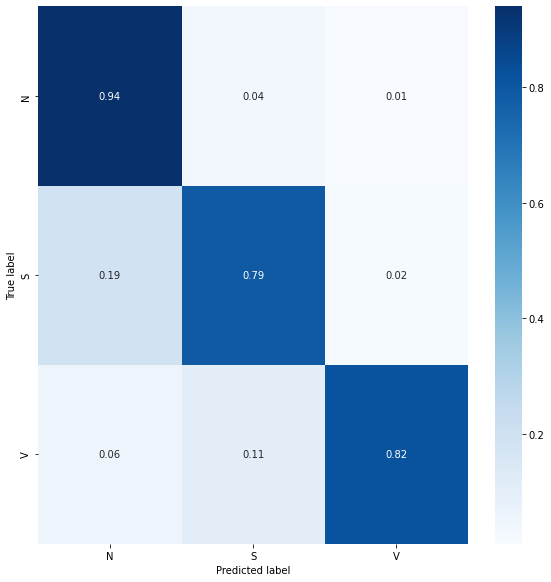

In [61]:
y_pred = KNN.predict(x_valid[:,:,0])
plot_confusion_matrix(y_valid,y_pred)

In [62]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     20802
           1       0.16      0.79      0.26       225
           2       0.71      0.82      0.76       871

    accuracy                           0.94     21898
   macro avg       0.62      0.85      0.66     21898
weighted avg       0.97      0.94      0.95     21898



<h3> RFC 

In [63]:
from sklearn.ensemble import RandomForestClassifier

x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_balanced_patches_df)
x_test,y_test = create_input(validation_patches_df)


rf = RandomForestClassifier(
    n_estimators= 200,
    random_state= SEED,
)

rf.fit(x_train[:,:,0],y_train)

100%|██████████| 21898/21898 [00:01<00:00, 12602.23it/s]


RandomForestClassifier(n_estimators=200, random_state=1)

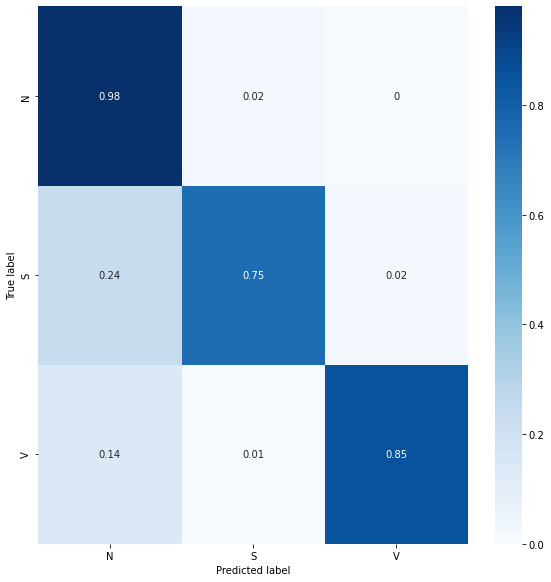

In [66]:
import seaborn as sns 
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  y_true = np.argmax(y_true,axis=1)
  y_pred = np.argmax(y_pred,axis=1)
  
  con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

y_pred = rf.predict(x_valid[:,:,0])
plot_confusion_matrix(y_valid,y_pred)

In [67]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     20802
           1       0.28      0.75      0.40       225
           2       0.99      0.85      0.91       871

   micro avg       0.98      0.95      0.96     21898
   macro avg       0.76      0.85      0.76     21898
weighted avg       0.99      0.95      0.97     21898
 samples avg       0.95      0.95      0.95     21898



C:\Users\simon\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
validation_df['sigId']

82    S096
98    S112
10    S011
93    S107
97    S111
35    S036
94    S108
58    S059
37    S038
18    S019
Name: sigId, dtype: object